# Time sampling interpolation

The aim of this notebook is to create and document the techniques needed to bring some sampled data signal (e.g. fgm) onto the same time cadance as some other sampled data signal (e.g. fpi).  The idea here is to take two signals like the following:

<pre>
epoch   0123456789012345678901234567890123456789012345678901234567890
                  1         2         3         4         5         6
sample1       x  x  x  x  x  x  x  x  x  x  x  x  x  x  x  x  x  x  x
sample2     o     o     o     o     o     o     o     o     o     o
</pre>

and to estimate the value of the x's at the time that the o's occurred, taking into account that the x's may not be available when the o's need them.  In other words, the o-signal is the subscriber and the x-signal is the provider; the request is one-way.  Despite the way it looks above, generally the o- and x-signals will have no points in common.  The estimated value for the x-signal will be refered to as the x'-signal

The requirements are:

1) The x- and o-signals will be held in numpy arrays with the corresponding datetime objects in another numpy array.  The epoch arrays are assumed to be the same length as the signals themselves (i.e. from a properly formed CDF).

2) Find the knots in the x-signal that bracket the o-signal
    a) return the indices of the pair that bracket
    b) if a pair doesn't exist, flag the x'-signal as masked
    
3) linearly interpolate between the bracketing values and place the derived value into a numpy array of exactly the same length as the o-signal and assume that the x'-signal shares the same epoch array as the o-signal.

Open questions:

How does numpy compute with two arrays when one is masked?  In other words, what signal will derive from the o- and x'-signals, if some of the x'-signal knots are marked as masked-invalid?

# Answering the open question

To answer this question, lets consider two simple arrays A and B each of length 5 and in which A is fully unmasked but B is missing some entries.  Then let us see what happens to the derived C if A and B are multiplied.

In [23]:
A = np.array([1,2,3,4,5])
B = np.ma.masked_array(np.array([1,-1,1,-1,1]),mask=[0,0,1,1,0])
C = A*B
print "C is:", C
print "The length of C is:", len(C)

C is: [1 -2 -- -- 5]
The length of C is: 5


So the masked array facility gives a nice way to handle everything and no problems are perceived.

# Implementing the interpolation

The three situations to be addressed are:

1) estimating fields data to particle data - prototype will be fgm to fpi electrons

2) estimating spacecraft position data (oddly repeated in fgm - their user base must have wanted not to get into the mec files) to particle data

3) for fun and testing - estimating particle data to fgm; this one is the most challenging as there are generally many fgm points falling between des or dis points.  We shall see if this is needed or neccessary

## Make the functions

In [81]:
def bisect_epochs(target_epoch,epochs):

    #test to make sure that target_epoch falls within the epochs array
    #if not send back identical indices (start or end)
    if (target_epoch - epochs[0]).total_seconds() < 0.0:
        return np.nan, np.nan
    if (target_epoch - epochs[-1]).total_seconds() > 0.0:
        return np.nan, np.nan
    
    #bisect to find bracketing points
    low_index  = 0
    high_index = len(epochs)
    
    old_trial_index = low_index
    trial_index     = high_index
    
    counter = 0
    while( abs(old_trial_index - trial_index) > 1 ):
        old_trial_index = trial_index
        trial_index     = np.int(np.floor((high_index+low_index)/2.0))
        trial_epoch     = epochs[trial_index]
        if (trial_epoch - target_epoch).total_seconds() < 0.0:
            low_index  = trial_index
        else:
            high_index = trial_index
        #print counter, low_index, high_index, trial_index
        counter += 1

    #a test for what may happen for an odd number of points 
    #in the epochs array
    if(high_index == low_index):
        #find out if the common epoch is above or below the target
        if (epochs[high_index] - target_epoch).total_seconds() < 0.0:
            high_index = high_index + 1
        else:
            low_index = low_index - 1
            
    return low_index, high_index

In [92]:
def estimate_signal_to_sample(o_epoch,x_epochs,x_values):
    
    #find the bracketing point
    low_index, high_index = bisect_epochs(o_epoch,x_epochs)

    #if the bracketing doesn't exist then return a nan
    if np.isnan(low_index) and np.isnan(high_index):
        return np.nan
    
    #if brackets exist, perform linear interpolation
    if high_index-low_index > 1:
        print '''Bracketing problem detected!!! info as follows:
                 o_epoch:    %s
                 low_index:  %s
                 high_index: %s''' % (o_epoch, low_index, high_index)
    delta_t = (x_epochs[high_index] - x_epochs[low_index]).total_seconds()
    delta_x = x_values[high_index]  - x_values[low_index]
    alpha   = (o_epoch - x_epochs[low_index]).total_seconds()
    xp_val  = x_values[low_index] + alpha*delta_x/delta_t
    
    return xp_val

## Locate the files and read in the data

In [31]:
fgm_f = '/fpiprd1/data/ftp/mms1/fgm/brst/l2/2017/06/08/mms1_fgm_brst_l2_20170608133933_v5.92.0.cdf'
fpi_f = '/fpiprd1/data/ftp/mms1/fpi/brst/l2/des-moms/2017/06/08/mms1_fpi_brst_l2_des-moms_20170608133933_v3.2.0.cdf'

In [32]:
fgm = pycdf.CDF(fgm_f)
fpi = pycdf.CDF(fpi_f)

In [38]:
fgm_epoch = np.asarray(fgm['Epoch'])
fgm_B     = np.asarray(fgm['mms1_fgm_b_gse_brst_l2'])
fpi_epoch = np.asarray(fpi['Epoch'])
fpi_ne    = np.asarray(fpi['mms1_des_numberdensity_brst'])

The analysis of the epochs of the fgm relative to the fpi show that the fpi epochs start earlier and are not bracketed until index 18.  

Thus the first 18 points in the derived array should be masked.

In [52]:
print fgm_epoch[0]
print fpi_epoch[0]

2017-06-08 13:39:33.513035
2017-06-08 13:39:33.001312


In [53]:
[(i,(fpi_epoch[i] - fgm_epoch[0]).total_seconds()) for i in range(25)]

[(0, -0.511723),
 (1, -0.481723),
 (2, -0.451723),
 (3, -0.421723),
 (4, -0.391723),
 (5, -0.361723),
 (6, -0.331723),
 (7, -0.301723),
 (8, -0.271723),
 (9, -0.241723),
 (10, -0.211723),
 (11, -0.181723),
 (12, -0.151723),
 (13, -0.121723),
 (14, -0.091723),
 (15, -0.061723),
 (16, -0.031723),
 (17, -0.001723),
 (18, 0.028277),
 (19, 0.058277),
 (20, 0.088277),
 (21, 0.118277),
 (22, 0.148277),
 (23, 0.178277),
 (24, 0.208277)]

One the other end, the fgm file actually extends past the last fpi point so there seems to be no issues on this end.

In [54]:
print fgm_epoch[-1]
print fpi_epoch[-1]

2017-06-08 13:41:33.506572
2017-06-08 13:41:32.971938


In [58]:
[(i,(fgm_epoch[-1]-fpi_epoch[-(25-i)]).total_seconds()) for i in range(25)]

[(0, 1.254634),
 (1, 1.224634),
 (2, 1.194634),
 (3, 1.164634),
 (4, 1.134634),
 (5, 1.104634),
 (6, 1.074634),
 (7, 1.044634),
 (8, 1.014634),
 (9, 0.984634),
 (10, 0.954634),
 (11, 0.924634),
 (12, 0.894634),
 (13, 0.864634),
 (14, 0.834634),
 (15, 0.804634),
 (16, 0.774634),
 (17, 0.744634),
 (18, 0.714634),
 (19, 0.684634),
 (20, 0.654634),
 (21, 0.624634),
 (22, 0.594634),
 (23, 0.564634),
 (24, 0.534634)]

# Time to test and learn

In [115]:
xp_vals = []
for i in range(len(fpi_epoch)):
    temp_val = estimate_signal_to_sample(fpi_epoch[i],fgm_epoch,fgm_B[:,3])
    xp_vals.append(temp_val)
xp_vals = np.ma.masked_invalid(np.asarray(xp_vals))

In [116]:
xp_vals

masked_array(data = [-- -- -- ..., 11.716346972182782 11.705137661839057 11.685402769830004],
             mask = [ True  True  True ..., False False False],
       fill_value = 1e+20)

Now try a hand calculation to test

In [170]:
targ_epoch = fpi_epoch[29]
print targ_epoch

2017-06-08 13:39:33.871312


In [178]:
print fgm_epoch[45]
print fgm_epoch[46]
print fgm_epoch[47]
print "fgm's 46 and 45 bracket the point"

2017-06-08 13:39:33.864602
2017-06-08 13:39:33.872414
2017-06-08 13:39:33.880227
fgm's 46 and 45 bracket the point


In [184]:
delta_t    = (fgm_epoch[46]-fgm_epoch[45]).total_seconds()
delta_Bmag = fgm_B[46,3] - fgm_B[45,3]
Bmag_est   = fgm_B[45,3] + delta_Bmag/delta_t*( (targ_epoch-fgm_epoch[45]).total_seconds() )
print Bmag_est, xp_vals[29]

11.5838682665 11.5838682665


Now look at some plots at 1-second intervals along the way (more or less randomly selected)

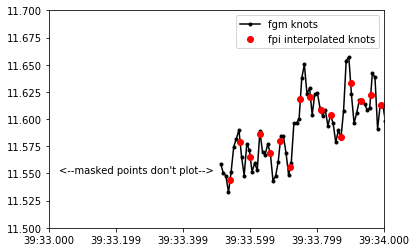

In [243]:
N = 0
start_time = mpl.dates.date2num(fpi_epoch[N])
stop_time  = start_time + 1.0/86400.0
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.plot(fgm_epoch,fgm_B[:,3],'k.-',label='fgm knots')
ax.plot(fpi_epoch,xp_vals,'ro',label='fpi interpolated knots')
ax.set_xlim([start_time,stop_time])
ax.set_ylim([11.5,11.7])
ax.legend()
ax.annotate("<--masked points don't plot-->",xy=(start_time + 0.03/86400.0,11.55))
custom_labels = []
for xx in ax.xaxis.get_majorticklocs():
    custom_labels.append(dt.datetime.strftime(mdates.num2date(xx),"%M:%S.%f")[:-3])
ax.xaxis.set_ticklabels(custom_labels)    
plt.show()

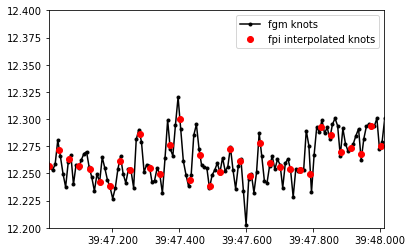

In [244]:
N = 467
start_time = mpl.dates.date2num(fpi_epoch[N])
stop_time  = start_time + 1.0/86400.0
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.plot(fgm_epoch,fgm_B[:,3],'k.-',label='fgm knots')
ax.plot(fpi_epoch,xp_vals,'ro',label='fpi interpolated knots')
ax.set_xlim([start_time,stop_time])
ax.set_ylim([12.2,12.4])
ax.legend()
custom_labels = []
for xx in ax.xaxis.get_majorticklocs():
    custom_labels.append(dt.datetime.strftime(mdates.num2date(xx),"%M:%S.%f")[:-3])
ax.xaxis.set_ticklabels(custom_labels)    
plt.show()

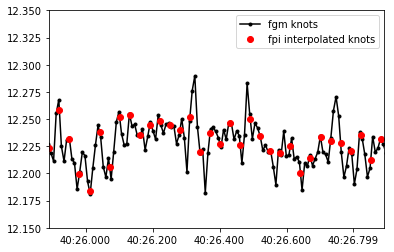

In [245]:
N = 1763
start_time = mpl.dates.date2num(fpi_epoch[N])
stop_time  = start_time + 1.0/86400.0
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.plot(fgm_epoch,fgm_B[:,3],'k.-',label='fgm knots')
ax.plot(fpi_epoch,xp_vals,'ro',label='fpi interpolated knots')
ax.set_xlim([start_time,stop_time])
ax.set_ylim([12.15,12.35])
ax.legend()
custom_labels = []
for xx in ax.xaxis.get_majorticklocs():
    custom_labels.append(dt.datetime.strftime(mdates.num2date(xx),"%M:%S.%f")[:-3])
ax.xaxis.set_ticklabels(custom_labels)    
plt.show()

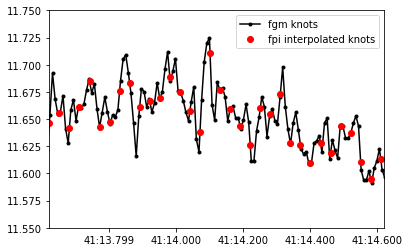

In [246]:
N = 3354
start_time = mpl.dates.date2num(fpi_epoch[N])
stop_time  = start_time + 1.0/86400.0
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.plot(fgm_epoch,fgm_B[:,3],'k.-',label='fgm knots')
ax.plot(fpi_epoch,xp_vals,'ro',label='fpi interpolated knots')
ax.set_xlim([start_time,stop_time])
ax.set_ylim([11.55,11.75])
ax.legend()
custom_labels = []
for xx in ax.xaxis.get_majorticklocs():
    custom_labels.append(dt.datetime.strftime(mdates.num2date(xx),"%M:%S.%f")[:-3])
ax.xaxis.set_ticklabels(custom_labels)    
plt.show()

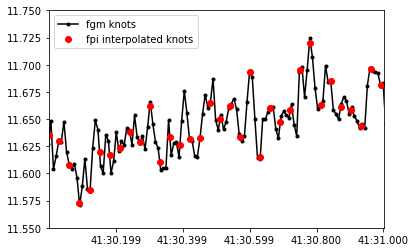

In [247]:
N = 3900
start_time = mpl.dates.date2num(fpi_epoch[N])
stop_time  = start_time + 1.0/86400.0
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.plot(fgm_epoch,fgm_B[:,3],'k.-',label='fgm knots')
ax.plot(fpi_epoch,xp_vals,'ro',label='fpi interpolated knots')
ax.set_xlim([start_time,stop_time])
ax.set_ylim([11.55,11.75])
ax.legend()
custom_labels = []
for xx in ax.xaxis.get_majorticklocs():
    custom_labels.append(dt.datetime.strftime(mdates.num2date(xx),"%M:%S.%f")[:-3])
ax.xaxis.set_ticklabels(custom_labels)    
plt.show()

Things look quite good.

# Side quest - date and time formatting on the x-axis

Some of it is done in the 'Matplotlib Date-Time on the X-axis' notebook but a key lesson is this:

* use the locators to find the ticks
* query the ticks for their locs (locations)
* num2date the locs into dates and datetime.strftime into the desired format - this is the most robust and dependable way